In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Predicting College Major Enrollment

### Stat 426 Final Project

A few years ago, Five Thirty Eight published an article about the salaries of various college majors. The article explored which degrees could be the most profitable for students. This made me curious: do students actually flock to higher paying degrees? From what I've observed in my college experience, many male BYU students do choose higher paying career paths because they are concerned about providing for a family. Yet many other college students around the country complain that they are unable to pay off their student loans— is this the result of many students choosing lower paying jobs? I decided to analyze the same dataset to see if economic factors such as wages and unemployment rates did have an effect on how many people enrolled in a particular program. Do more students choose higher paying jobs or lower paying jobs? The data I am exploring from Five Thirty Eight is originally from the American Community Survey 2010-2012 Public Use Microdata Series.

In [378]:
#Reading in the data
table2 = pd.read_html("https://github.com/fivethirtyeight/data/blob/master/college-majors/grad-students.csv")

In [379]:
gradstudent = table2[0]
gradstudent.head()

,Unnamed: 0,Major_code,Major,Major_category,Grad_total,Grad_sample_size,Grad_employed,Grad_full_time_year_round,Grad_unemployed,Grad_unemployment_rate,...,Nongrad_total,Nongrad_employed,Nongrad_full_time_year_round,Nongrad_unemployed,Nongrad_unemployment_rate,Nongrad_median,Nongrad_P25,Nongrad_P75,Grad_share,Grad_premium
0,NaN,5601,CONSTRUCTION SERVICES,Industrial Arts & Consumer Services,9173,200,7098,6511,681,0.087543,...,86062,73607,62435,3928,0.050661,65000.0,47000,98000.0,0.096320,0.153846
1,NaN,6004,COMMERCIAL ART AND GRAPHIC DESIGN,Arts,53864,882,40492,29553,2482,0.057756,...,461977,347166,250596,25484,0.068386,48000.0,34000,71000.0,0.104420,0.250000
2,NaN,6211,HOSPITALITY MANAGEMENT,Business,24417,437,18368,14784,1465,0.073867,...,179335,145597,113579,7409,0.048423,50000.0,35000,75000.0,0.119837,0.300000
3,NaN,2201,COSMETOLOGY SERVICES AND CULINARY ARTS,Industrial Arts & Consumer Services,5411,72,3590,2701,316,0.080901,...,37575,29738,23249,1661,0.052900,41600.0,29000,60000.0,0.125878,0.129808
4,NaN,2001,COMMUNICATION TECHNOLOGIES,Computers & Mathematics,9109,171,7512,5622,466,0.058411,...,53819,43163,34231,3389,0.072800,52000.0,36000,78000.0,0.144753,0.096154


### Data Cleaning

To clean the data, I am going to be dropping some unnecessary columns. I am also going to rearrange the table and create a variable that indicates what type of degree the student is getting (graduate or undergraduate).

In [380]:
#Drop the Unnamed: 0 column, which has no useful data
gradstudent.drop('Unnamed: 0', inplace=True, axis=1)

In [381]:
justgrad = gradstudent[['Major', 'Major_category', 'Grad_total', 'Grad_employed', 'Grad_unemployed', 'Grad_unemployment_rate', 'Grad_median', 'Grad_P25', 'Grad_P75']]
justnongrad = gradstudent[['Major', 'Major_category', 'Nongrad_total', 'Nongrad_employed', 'Nongrad_unemployed', 'Nongrad_unemployment_rate', 'Nongrad_median', 'Nongrad_P25', 'Nongrad_P75']]

In [382]:
#renaming columns
justnongrad = justnongrad.rename(columns={"Nongrad_total": "Totalnum", "Nongrad_employed": "Employed", "Nongrad_unemployed": "Unemployed", "Nongrad_unemployment_rate": "Unemployment_rate", "Nongrad_median": "Median_wage", "Nongrad_P25": "Q25_wage", "Nongrad_P75": "Q75_wage"})
justgrad = justgrad.rename(columns={"Grad_total": "Totalnum", "Grad_employed": "Employed", "Grad_unemployed": "Unemployed", "Grad_unemployment_rate": "Unemployment_rate", "Grad_median": "Median_wage", "Grad_P25": "Q25_wage", "Grad_P75": "Q75_wage"})

In [383]:
#creating degree variable
justgrad['degree'] = "grad"
justnongrad['degree'] = "undergrad"

In [384]:
#combining tables, setting index
college = justnongrad.append(justgrad)
college = college.reset_index().drop('index', axis=1)
college.set_index('Major', inplace=True)

In [385]:
#Dropping some more variables that are redundant
college.drop('Employed', axis=1, inplace=True)
college.drop('Unemployed', axis=1, inplace=True)

In [386]:
college.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346 entries, CONSTRUCTION SERVICES to EDUCATIONAL ADMINISTRATION AND SUPERVISION
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Major_category     346 non-null    object 
 1   Totalnum           346 non-null    int64  
 2   Unemployment_rate  346 non-null    float64
 3   Median_wage        346 non-null    float64
 4   Q25_wage           346 non-null    int64  
 5   Q75_wage           346 non-null    float64
 6   degree             346 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 21.6+ KB


In [387]:
college

,Major_category,Totalnum,Unemployment_rate,Median_wage,Q25_wage,Q75_wage,degree
Major,,,,,,,
CONSTRUCTION SERVICES,Industrial Arts & Consumer Services,86062,0.050661,65000.0,47000,98000.0,undergrad
COMMERCIAL ART AND GRAPHIC DESIGN,Arts,461977,0.068386,48000.0,34000,71000.0,undergrad
HOSPITALITY MANAGEMENT,Business,179335,0.048423,50000.0,35000,75000.0,undergrad
COSMETOLOGY SERVICES AND CULINARY ARTS,Industrial Arts & Consumer Services,37575,0.052900,41600.0,29000,60000.0,undergrad
COMMUNICATION TECHNOLOGIES,Computers & Mathematics,53819,0.072800,52000.0,36000,78000.0,undergrad
...,...,...,...,...,...,...,...
COUNSELING PSYCHOLOGY,Psychology & Social Work,51812,0.035600,50000.0,36000,65000.0,grad
CLINICAL PSYCHOLOGY,Psychology & Social Work,22716,0.044958,70000.0,47000,95000.0,grad
HEALTH AND MEDICAL PREPARATORY PROGRAMS,Health,114971,0.021687,135000.0,70000,294000.0,grad


### Exploratory Data Analysis

To explore the data, I am going to look at some plots and summary statistics to get an idea of what the data look like.

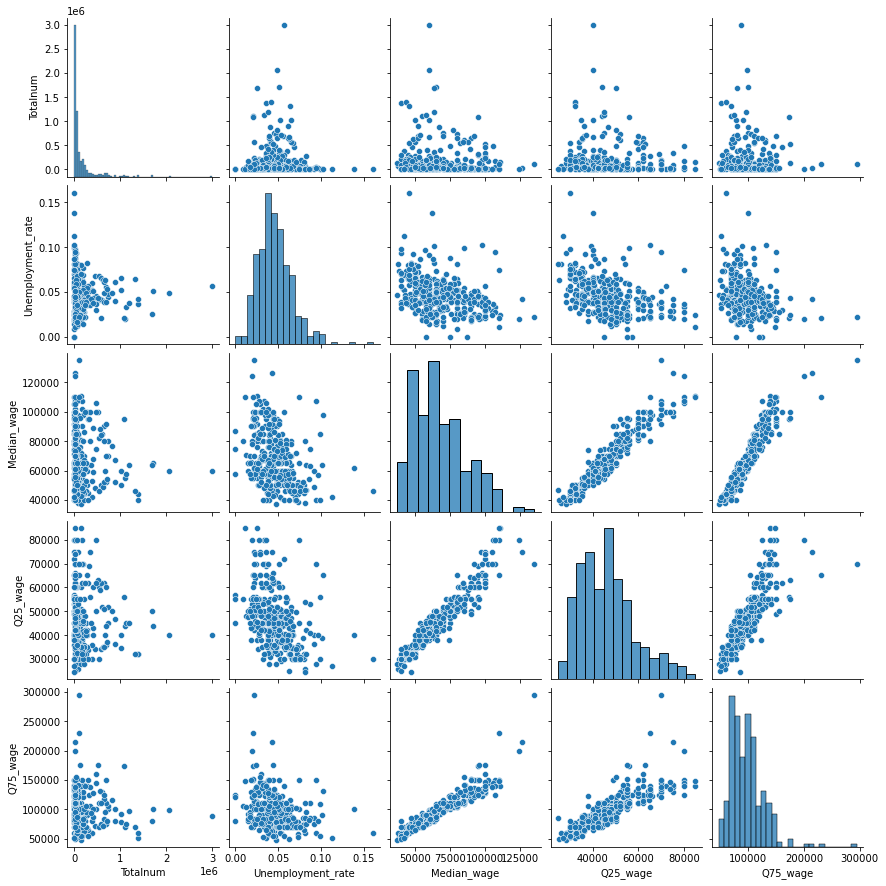

In [388]:
#Pairplot of the variables
import seaborn as sns
sns.pairplot(college)

It looks like some of the variables are correlated. All 3 wage metrics are correlated, so I will try dropping two of them when looking at feature importance.

Text(0.5, 1.0, 'Median Wage vs Enrollment')

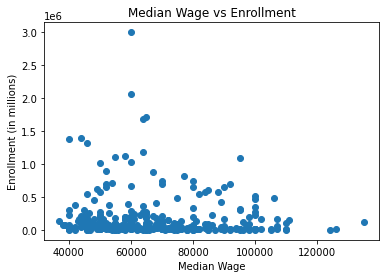

In [389]:
#plot of wages and enrollment
plt.scatter(college['Median_wage'], college['Totalnum'])
plt.xlabel("Median Wage")
plt.ylabel("Enrollment (in millions)")
plt.title("Median Wage vs Enrollment")

Text(0.5, 1.0, 'Unemployment Rate vs Enrollment')

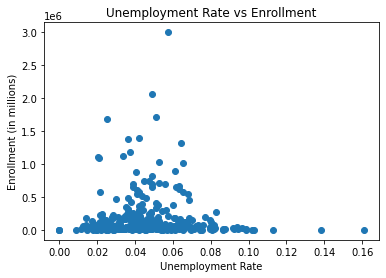

In [390]:
#plot of unemployment and enrollment
plt.scatter(college['Unemployment_rate'], college['Totalnum'])
plt.xlabel("Unemployment Rate")
plt.ylabel("Enrollment (in millions)")
plt.title("Unemployment Rate vs Enrollment")

An initial look at a plot of median wage and student enrollment does not show any obvious trends. Most majors seems to have below average enrollment numbers. The points look more densely populated around low salary and low enrollment than around high salary and low enrollment.

In [391]:
#Means and Medians for different variables
print(college.mean())
print(college.median())
print(college[college['degree'] == 'grad'].mean())
print(college[college['degree'] == 'grad'].median())
print(college[college['degree'] == 'undergrad'].mean())
print(college[college['degree'] == 'undergrad'].median())

Totalnum             171196.167630
Unemployment_rate         0.046645
Median_wage           67669.797688
Q25_wage              46337.343931
Q75_wage              98210.144509
dtype: float64
Totalnum             54011.500000
Unemployment_rate        0.044623
Median_wage          65000.000000
Q25_wage             45000.000000
Q75_wage             95000.000000
dtype: float64
Totalnum             127672.023121
Unemployment_rate         0.039343
Median_wage           76755.780347
Q25_wage              52596.508671
Q75_wage             112087.341040
dtype: float64
Totalnum              37872.000000
Unemployment_rate         0.036654
Median_wage           75000.000000
Q25_wage              50000.000000
Q75_wage             108000.000000
dtype: float64
Totalnum             214720.312139
Unemployment_rate         0.053947
Median_wage           58583.815029
Q25_wage              40078.179191
Q75_wage              84332.947977
dtype: float64
Totalnum             68993.000000
Unemployment_rate    

In [392]:
college['Totalnum'].sort_values()

Major
COURT REPORTING                                                         1542
MISCELLANEOUS FINE ARTS                                                 1733
SCHOOL STUDENT COUNSELING                                               2232
ACTUARIAL SCIENCE                                                       2472
ELECTRICAL, MECHANICAL, AND PRECISION TECHNOLOGIES AND PRODUCTION       3187
                                                                      ...   
GENERAL EDUCATION                                                    1388324
NURSING                                                              1686899
ACCOUNTING                                                           1708418
GENERAL BUSINESS                                                     2056867
BUSINESS MANAGEMENT AND ADMINISTRATION                               2996892
Name: Totalnum, Length: 346, dtype: int64

The mean number of graduate students enrolled is 127672, but the median is only 37872. Likewise, the mean number of undergraduate students is 214720, while the median is only 68993. The few majors with extremely large enrollment, like the undergraduate program in Business Management and Administration, are skewing the averages.

In [393]:
print("Minimum number of people in a college program:", college['Totalnum'].min())
print("Maximum number of people in a college program:", college['Totalnum'].max())
print("Range:", college['Totalnum'].max() - college['Totalnum'].min())

Minimum number of people in a college program: 1542
Maximum number of people in a college program: 2996892
Range: 2995350


### Models

I am going to try a variety of models to see which one can best predict how many students are enrolled in a major. First, I am going to do a basic Linear Regression. Linear Regression is a great first look at the data. I am also going to look at Lasso and Ridge regression because the two methods adjust the coefficients for the variables so the more important variables are contributing more to the final predictions. Lastly, I am going to look at K Neighbors and Decision Trees. I will compare the root mean square error in each model to find the one with the least error.

In [394]:
#Separating response variable from the features
X = pd.concat([college.iloc[:,0:1], college.iloc[:,2:]], axis=1)
y = college['Totalnum']

In [395]:
#Encoding the categorical variables as dummy variables so we can use them in our regression models
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_encoded = encoder.fit_transform(X)

C:\Users\rhunter\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [396]:
#Split the data into testing and training sets
#I am stratifying based on type of degree, because there are generally fewer graduate students
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 385, test_size = 0.25, stratify=X_encoded['degree_grad'])

Linear Regression

In [397]:
lm = LinearRegression()
lm.fit(X_train, y_train)
yhat_lm = lm.predict(X_test)
mse_lm = mean_squared_error(y_test, yhat_lm)
print("Root Mean Squared Error:", np.sqrt(mse_lm))
print("Mean Absolute Error:", mean_absolute_error(y_test, yhat_lm))

Root Mean Squared Error: 242431.45524504167
Mean Absolute Error: 176302.66780445795


Lasso Regression:
Lasso can make the coefficients of unimportant factors 0, but it may not work with all types of data.

In [398]:
lass = Lasso(alpha=3)
lass.fit(X_train, y_train)
yhat_lass = lass.predict(X_test)
mse_lass = mean_squared_error(y_test, yhat_lass)
print("Root Mean Squared Error:", np.sqrt(mse_lass))
print("Mean Absolute Error:", mean_absolute_error(y_test, yhat_lass))

Root Mean Squared Error: 242443.4290509495
Mean Absolute Error: 176300.09494422065


Ridge Regression:
Ridge can make the coefficients of unimportant factors very small, but it may struggle with certain types of data.

In [399]:
ridg = Ridge(alpha=.0001)
ridg.fit(X_train, y_train)
yhat_ridg = ridg.predict(X_test)
mse_ridg = mean_squared_error(y_test, yhat_ridg)
print("Root Mean Squared Error:", np.sqrt(mse_ridg))
print("Mean Absolute Error:", mean_absolute_error(y_test, yhat_ridg))

Root Mean Squared Error: 242436.4941595858
Mean Absolute Error: 176301.95410764325


K Neighbors Regression: K neighbors looks at data points with similar features to figure out predictions. It is often quite accurate, but might not perform well on our outliers.

In [400]:
#Find best parameter
from sklearn.model_selection import GridSearchCV
parameters_knn = {'n_neighbors':list(range(1,30))}
knncv = KNeighborsRegressor()
parknncv = GridSearchCV(knncv, parameters_knn)
parknncv.fit(X_train, y_train)
parknncv.best_params_

{'n_neighbors': 28}

In [401]:
knn = KNeighborsRegressor(n_neighbors=28)
knn.fit(X_train, y_train)
yhat_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, yhat_knn)
print("Root Mean Squared Error:", np.sqrt(mse_knn))
print("Mean Absolute Error:", mean_absolute_error(y_test, yhat_knn))

Root Mean Squared Error: 208322.0840649877
Mean Absolute Error: 159680.66666666672


Decision Tree Regression: 
Decision trees are very intuitive to understand, but they can also be very sensitive to small changes in data.

In [402]:
tree = DecisionTreeRegressor(min_samples_leaf=3)
tree.fit(X_train, y_train)
yhat_tree = tree.predict(X_test)
mse_tree = mean_squared_error(y_test, yhat_tree)
print("Root Mean Squared Error:", np.sqrt(mse_tree))
print("Mean Absolute Error:", mean_absolute_error(y_test, yhat_tree))

Root Mean Squared Error: 328364.45124334656
Mean Absolute Error: 187546.50957854406


The best model out of these 5 is a K Neighbors Regressor. It has a root mean squared error of 208322 and a mean absolute error of 159680. Both of these measurements were the lower compared to the corresponding measurement of the other models. Although it is the most accurate, the root mean squared error is still pretty big, especially considering that the average number of students enrolled in a major was 171196. There is a very large range in our data, spanning 2995350.

I used GridSearchCV to choose the best hyperparameters for my models. For my K Neighbors Regressor, the best hyperparameter was 28.

In [403]:
#Evaluating Model Performance
#Cross Validated Model Performance
scores_knn = cross_val_score(knn, X_encoded, y, cv=10, scoring='neg_mean_squared_error')
mse_knn_cv = -1*scores_knn.mean()
print("CV Root Mean Squared Error:", np.sqrt(mse_knn_cv))

CV Root Mean Squared Error: 333261.4062367283


In cross validation, my model did not perform very well. The average root mean squared error of my cross validation trials was 333261, which is much bigger than the root mean squared error from my model's training set. Because this model has such high errors, I'm not confident that it can accurately predict how many students are enrolled in a major based on economic information.

In [404]:
#Looking at coefficients for the reatures to see relative importance
#removing percentiles for wage and just looking at median wage
x = X_train.drop('Q25_wage', axis=1)
x.drop('Q75_wage', axis=1, inplace=True)
lmx = LinearRegression()
lmx.fit(ex, y_train)
feature_names = list(ex.columns.values)
list(zip(lmx.coef_, feature_names))

[(-54045.22717077238, 'Major_category_Industrial Arts & Consumer Services'),
 (-11341.243751724425, 'Major_category_Arts'),
 (429414.6335566854, 'Major_category_Business'),
 (-46211.12199257608, 'Major_category_Computers & Mathematics'),
 (-47535.08739525528, 'Major_category_Law & Public Policy'),
 (-173249.0285572183, 'Major_category_Agriculture & Natural Resources'),
 (97755.0845611379, 'Major_category_Communications & Journalism'),
 (-131953.87011979855, 'Major_category_Engineering'),
 (107773.46753205455, 'Major_category_Social Science'),
 (-5065.382069103262, 'Major_category_Health'),
 (-146836.136242335, 'Major_category_Interdisciplinary'),
 (-119339.30108950294, 'Major_category_Physical Sciences'),
 (41614.259334271395, 'Major_category_Humanities & Liberal Arts'),
 (69993.91149008226, 'Major_category_Psychology & Social Work'),
 (-100565.18406684167, 'Major_category_Biology & Life Science'),
 (89590.22603794931, 'Major_category_Education'),
 (-2168137.9954188573, 'Unemployment_r

Based on these coefficients from the basic linear model, wages do have an effect on student enrollment. A higher median wage means more people choose that major. Unemployment rate also impacts the number of students enrolled in a major; generally as unemployment rate goes up, the number of students enrolled in the major goes down. This suggests that people gravitate more toward degrees with lower unemployment rates.

### Conclusions

Economic factors can help us predict how many students are enrolled in a major or program. If a college major had a greater median wage, more people chose that program. At the same time, a lower unemployment rate was also associated with more students enrolling in that major. This suggests that students are indeed choosing majors that will be good for them economically. 

This data is a few years old, and there are lots of other variables that could have been included in an analysis like this. I would be interested in trying to answer the same question with a bigger dataset.